## CS 238 Final Project SushiGo! SARSA (and Q-learning)
Peyton Chen, Kevin Guo, Brandon Kang

Fall 2021, Stanford University

In [8]:
from scipy.stats import rankdata
import random
import copy
from tqdm import tqdm
import ast

from matplotlib import pyplot as plt
%matplotlib inline

### Constants that will be used throughout code representation of game:

In [3]:
ONE_MAKI = 'One maki' # Card type
TWO_MAKI = 'Two maki' # Card type
THREE_MAKI = 'Three maki' # Card type
WASABI_SQUID = 'Wasabi Squid' # Board type
WASABI_SALMON = 'Wasabi Salmon' # Board type
WASABI_EGG = 'Wasabi Egg' # Board type
MAKI = 'Maki' # Board type

TEMPURA = 'Tempura' # Board and card type for rest
SASHIMI = 'Sashimi'
DUMPLINGS = 'Dumplings'
SQUID_NIGIRI = 'Squid Nigiri'
SALMON_NIGIRI = 'Salmon Nigiri'
EGG_NIGIRI = 'Egg Nigiri'
WASABI = 'Wasabi'
PUDDING = 'Pudding'

CHOPSTICKS = 'Chopsticks' # Unused just included for completeness

HAND_TO_INDEX = { # for cards in hand
    ONE_MAKI: 0,
    TWO_MAKI : 1,
    THREE_MAKI : 2,
    TEMPURA : 3,
    SASHIMI : 4,
    DUMPLINGS : 5,
    SQUID_NIGIRI : 6,
    SALMON_NIGIRI : 7,
    EGG_NIGIRI : 8,
    WASABI : 9,
    PUDDING : 10,
    CHOPSTICKS : 11 # unsed
}

BOARD_TO_INDEX = { # for board representation
    MAKI : 0,
    TEMPURA : 1,
    SASHIMI : 2,
    DUMPLINGS : 3,
    SQUID_NIGIRI : 4,
    SALMON_NIGIRI : 5,
    EGG_NIGIRI : 6,
    WASABI_SQUID : 7,
    WASABI_SALMON : 8,
    WASABI_EGG : 9,
    WASABI : 10,
    PUDDING : 11,
    CHOPSTICKS : 12 # unused
}

NUM_COMBO_BOARD = len(BOARD_TO_INDEX.keys())

### Player Classes

In [4]:
class SkeletonPlayer: # All Players will have these operations and class fields

    def __init__(self, name):
        self.name = name
        self.board = [0] * NUM_COMBO_BOARD
        self.hand = []

    def draw(self, card):
        self.hand.append(card)
    
    def add_card(self, board, card):
        if card == HAND_TO_INDEX[SASHIMI]:
            board[BOARD_TO_INDEX[SASHIMI]] += 1
        if card == HAND_TO_INDEX[EGG_NIGIRI]:
            if board[BOARD_TO_INDEX[WASABI]] > 0:
                board[BOARD_TO_INDEX[WASABI]] -= 1
                board[BOARD_TO_INDEX[WASABI_EGG]] += 1 
            else:
                board[BOARD_TO_INDEX[EGG_NIGIRI]] += 1
        if card == HAND_TO_INDEX[SALMON_NIGIRI]:
            if board[BOARD_TO_INDEX[WASABI]] > 0:
                board[BOARD_TO_INDEX[WASABI]] -= 1
                board[BOARD_TO_INDEX[WASABI_SALMON]] += 1 
            else:
                board[BOARD_TO_INDEX[SALMON_NIGIRI]] += 1
        if card == HAND_TO_INDEX[SQUID_NIGIRI]:
            if board[BOARD_TO_INDEX[WASABI]] > 0:
                board[BOARD_TO_INDEX[WASABI]] -= 1
                board[BOARD_TO_INDEX[WASABI_SQUID]] += 1 
            else:
                board[BOARD_TO_INDEX[SQUID_NIGIRI]] += 1
        if card == HAND_TO_INDEX[ONE_MAKI]:
            board[BOARD_TO_INDEX[MAKI]] += 1
        if card == HAND_TO_INDEX[TWO_MAKI]:
            board[BOARD_TO_INDEX[MAKI]] += 2
        if card == HAND_TO_INDEX[THREE_MAKI]:
            board[BOARD_TO_INDEX[MAKI]] += 3
        if card == HAND_TO_INDEX[TEMPURA]:
            board[BOARD_TO_INDEX[TEMPURA]] += 1
        if card == HAND_TO_INDEX[DUMPLINGS]:
            board[BOARD_TO_INDEX[DUMPLINGS]] += 1
        if card == HAND_TO_INDEX[PUDDING]:
            board[BOARD_TO_INDEX[PUDDING]] += 1
        if card == HAND_TO_INDEX[WASABI]:
            board[BOARD_TO_INDEX[WASABI]] += 1

    def pick_card(self): # Different kind of players pick cards differently
        raise NotImplementedError

    def get_score(self):
        score = 0
        num_dumplings = self.board[BOARD_TO_INDEX[DUMPLINGS]]
        if num_dumplings == 1:
            score += 1
        if num_dumplings == 2:
            score += 3
        if num_dumplings== 3:
            score += 6
        if num_dumplings == 4:
            score += 10
        if num_dumplings > 4: # 5 or more dumplings just 15 points
            score += 15
        
        score += self.board[BOARD_TO_INDEX[SASHIMI]] // 3 * 10
        score += self.board[BOARD_TO_INDEX[TEMPURA]] // 2 * 5  
        
        score += self.board[BOARD_TO_INDEX[EGG_NIGIRI]] * 1   
        score += self.board[BOARD_TO_INDEX[SALMON_NIGIRI]] * 2 
        score += self.board[BOARD_TO_INDEX[SQUID_NIGIRI]] * 3  
        
        score += self.board[BOARD_TO_INDEX[WASABI_EGG]] * 3 # Wasabi multiplies nigiri score by 3
        score += self.board[BOARD_TO_INDEX[WASABI_SALMON]] * 6  
        score += self.board[BOARD_TO_INDEX[WASABI_SQUID]] * 9  

        return score

    def reward(self, reward):
        raise NotImplementedError

    def next_round(self): # save pudding counts for next round (this is since pudding doesn't get scored until end of game)
        pudding_count = self.board[BOARD_TO_INDEX[PUDDING]]
        self.board = [0] * NUM_COMBO_BOARD
        self.board[BOARD_TO_INDEX[PUDDING]] = pudding_count
        self.hand = []

    def next_game(self): # reset both hand and board
        self.board = [0] * NUM_COMBO_BOARD
        self.hand = []

class RandomPlayer(SkeletonPlayer): # Selects card randomly

    def __init__(self, name):
        super().__init__(name)

    def draw(self, card):
        self.hand.append(card)
    
    def reward(self, reward):
        # Doesn't do anything with it
        return

    def pick_card(self):
        random.shuffle(self.hand)
        action = self.hand.pop()
        self.add_card(self.board, action)

class DumplingPlayer(SkeletonPlayer):

    def __init__(self, name):
        super().__init__(name)

    def draw(self, card):
        self.hand.append(card)
    
    def reward(self, reward):
        # Doesn't do anything with it, dumpling player never learns...
        return

    def pick_card(self): # If there are dumplings in hand, pick it, otherwise pick randomly
        if HAND_TO_INDEX[DUMPLINGS] in self.hand:
            action = HAND_TO_INDEX[DUMPLINGS]
            self.hand.remove(HAND_TO_INDEX[DUMPLINGS])
        else:
            random.shuffle(self.hand)
            action = self.hand.pop()
        self.add_card(self.board, action)

class SARSAPlayer(SkeletonPlayer):
    # Considers state, action in Q(s,a) as just state which is just the board reducing state action space
    def __init__(self, name):
        super().__init__(name)
        self.disc_factor = 0.3
        self.learning_rate = 0.01
        self.Q = {} # Data structure for state_action -> value
        self.seen = [str(self.board)]

    def draw(self, card):
        self.hand.append(card)
    
    def reward(self, reward):
        reversed_seen = list(reversed(self.seen))
        for i, state_action in enumerate(reversed_seen): # Reversed so that we access the "future" state_actions first and populate those entries
            if state_action not in self.Q:
                self.Q[state_action] = 0
            if i != 0:
                self.Q[state_action] += self.learning_rate * (reward + self.disc_factor * self.Q[reversed_seen[i - 1]] - self.Q[state_action])
            else:
                self.Q[state_action] += self.learning_rate * (reward - self.Q[state_action])

    def pick_card(self):
        action = None
        max_value = float('-inf')
        for card in set(self.hand):
            cpy = copy.copy(self.board)
            self.add_card(cpy, card)
            value = self.Q.get(str(cpy), 0) # if not seen (key doesn't exist), value is just 0
            if value > max_value:
                action = card
                max_value = value
        self.hand.remove(action)
        self.add_card(self.board, action)
        self.seen.append(str(self.board)) # Need to convert to str since mutable types like list aren't hashable

    def next_round(self):
        super().next_round()
        self.seen = [str(self.board)]

class BadQLearnPlayer(SkeletonPlayer):
    # Considers both state and action for Q(s, a) Problem is too many state action combos, doesn't really learn anything,
    # additionally, we only get reward in terminal state, so can simplify the problem with SARSAPlayer

    def __init__(self, name):
        super().__init__(name)
        self.disc_factor = 0.3
        self.learning_rate = 0.01
        self.Q = {} # Data structure for state_action -> value
        self.seen = []

    def pick_card(self):
        action = None
        max_value = float('-inf')
        for card in set(self.hand):
            value = self.Q.get((str(self.board), card), 0) # if not seen (key doesn't exist), value is just 0
            if value > max_value:
                action = card
                max_value = value
        self.hand.remove(action)
        self.seen.append((str(self.board), card)) # Need to convert to str since mutable types like list aren't hashable
        self.add_card(self.board, action)
    
    def max_Qprime_aprime(self, state_action):
        state, action = state_action
        state_cpy = copy.copy(ast.literal_eval(state))
        self.add_card(state_cpy, action)

        sprime_aprime = []
        for state, action in self.seen:
            if state == state_cpy:
                sprime_aprime.append((str(state_cpy), action))
        
        max = float('-inf')
        result_val = 0
        for sp_ap in sprime_aprime:
            temp = self.Q.get(sp_ap, 0)
            if temp > max:
                result_val = temp
                max = result_val
        return result_val
    
    def reward(self, reward):
        for state_action in reversed(self.seen): # Reversed so that we access the "future" state_actions first and populate those entries
            if state_action not in self.Q:
                self.Q[state_action] = 0
            self.Q[state_action] += self.learning_rate * (reward + self.disc_factor * self.max_Qprime_aprime(state_action) - self.Q[state_action])
        
    def next_round(self):
        super().next_round()
        self.seen = []

### Overarching SushiGo! class that interfaces with all the players

In [5]:
class SushiGo:

    def __init__(self, players):
        self.cards = self.get_all_cards()
        self.players = players
        self.starting_hand_size = self.determine_starting_hand_size()
        self.scores = [0] * len(players)
    
    def determine_starting_hand_size(self):
        num_players = len(self.players)
        if num_players == 2:
            return 10
        elif num_players == 3:
            return 9
        elif num_players == 4:
            return 8
        elif num_players == 5:
            return 7
        raise Exception('Unrecognized number of players must be between 2 - 5 players')

    def play_game(self, num_rounds=3):
        for player in self.players: 
            player.next_game() # reset players

        for round in range(num_rounds):
            self.deal() # deal cards
            for turn in range(self.starting_hand_size):
                for player in self.players: 
                    player.pick_card()
                self.pass_around_hands()
            for i, player in enumerate(self.players): 
                self.scores[i] += player.get_score()

            maki_scores = self.score_maki([player.board[BOARD_TO_INDEX[MAKI]] * -1 for player in self.players])
            for j in range(len(self.players)):
                self.scores[j] += maki_scores[j]

        pudding_score = self.score_pudding([player.board[BOARD_TO_INDEX[PUDDING]] * -1 for player in self.players])
        for i in range(len(self.players)):
            self.scores[i] += pudding_score[i]

        highest_score = max(self.scores)
        for i, player in enumerate(self.players):
            if self.scores[i] == highest_score:
                self.player_games_won[i] += 1
                player.reward(2)  # win
            else:
                player.reward(-1) # lose

    def play_games(self, num_games=1, num_rounds=3):
        self.player_games_won = [0] * len(self.players)
        for _ in range(num_games):
            self.reset()
            self.play_game(num_rounds=num_rounds)
    
    def score_maki(self, maki_counts):
        maki_scores = []
        maki_ranks = rankdata(maki_counts, method='min')
        for rank in maki_ranks:
            if rank == 1:
                maki_scores.append(6)
                continue
            if rank == 2:
                maki_scores.append(3)
                continue
            maki_scores.append(0)
        return maki_scores

    def score_pudding(self, pudding_counts):
        pudding_scores = []
        pudding_ranks = rankdata(pudding_counts, method='min')
        lowest_rank = max(pudding_ranks)
        for rank in pudding_ranks:
            if rank == 1:
                pudding_scores.append(6)
                continue
            if rank == lowest_rank:
                pudding_scores.append(-6)
                continue
            pudding_scores.append(0)
        return pudding_scores
    
    def get_all_cards(self):
        result = []
        result.extend([HAND_TO_INDEX[TEMPURA]] * 14)
        result.extend([HAND_TO_INDEX[SASHIMI]] * 14)
        result.extend([HAND_TO_INDEX[DUMPLINGS]] * 14)
        result.extend([HAND_TO_INDEX[ONE_MAKI]] * 6)
        result.extend([HAND_TO_INDEX[TWO_MAKI]] * 12)
        result.extend([HAND_TO_INDEX[THREE_MAKI]] * 8)
        result.extend([HAND_TO_INDEX[EGG_NIGIRI]] * 5)
        result.extend([HAND_TO_INDEX[SALMON_NIGIRI]] * 10)
        result.extend([HAND_TO_INDEX[SQUID_NIGIRI]] * 5)
        result.extend([HAND_TO_INDEX[PUDDING]] * 10)
        result.extend([HAND_TO_INDEX[WASABI]] * 6)

        return result

    def deal(self):
        for player in self.players:
            player.next_round() # reset player before drawing
            for _ in range(self.starting_hand_size):
                random.shuffle(self.cards)
                player.draw(self.cards.pop())
    
    def pass_around_hands(self):
        last_hand = self.players[-1].hand
        for i in range(len(self.players) - 1, 0, -1):
            self.players[i].hand = self.players[i - 1].hand  
        self.players[0].hand = last_hand  

    def reset(self):
        self.cards = self.get_all_cards()
        self.scores = [0] * len(self.players)
   
        

### 40,000 games of SARSA vs. Random vs. Brandon's beloved Dumpling player

In [172]:
p1 = SARSAPlayer('SARSA Player')
p2 = RandomPlayer('Random Player')
p3 = DumplingPlayer('Dumpling Player')
sushigo = SushiGo([p1, p2, p3])
results = []
  
for i in tqdm(range(200)):
    sushigo.play_games(num_games=200)
    results.append(sushigo.player_games_won)

100%|██████████| 200/200 [01:30<00:00,  2.22it/s]


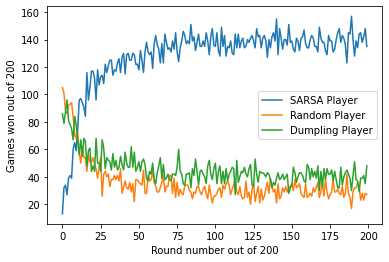

In [184]:
x = [i for i in range(200)]
player1y = [arr[0] for arr in results]
player2y = [arr[1] for arr in results]
player3y = [arr[2] for arr in results]

plt.plot(x, player1y, label = p1.name)
plt.plot(x, player2y, label = p2.name)
plt.plot(x, player3y, label = p3.name)
plt.legend()
plt.ylabel('Games won out of 200')
plt.xlabel('Round number out of 200')
plt.show()


### 40,000 games of different hyperparameters of SARSA

In [11]:
p4 = SARSAPlayer('SARSA Player 1')
p5 = SARSAPlayer('SARSA Player 2')
p5.learning_rate = 0.03 
p5.disc_factor = 0.7
p6 = SARSAPlayer('SARSA Player 3')
p6.learning_rate = 0.01
p6.disc_factor = 1
sushigo = SushiGo([p4, p5, p6])
results2 = []
  
for i in tqdm(range(200)):
    sushigo.play_games(num_games=200)
    results2.append(sushigo.player_games_won)

100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


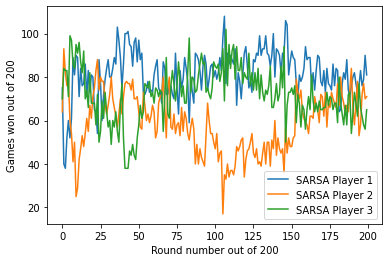

In [12]:
x = [i for i in range(200)]
player4y = [arr[0] for arr in results2]
player5y = [arr[1] for arr in results2]
player6y = [arr[2] for arr in results2]

plt.plot(x, player4y, label = p4.name)
plt.plot(x, player5y, label = p5.name)
plt.plot(x, player6y, label = p6.name)
plt.legend()
plt.ylabel('Games won out of 200')
plt.xlabel('Round number out of 200')
plt.show()


### 40,000 games of SARSA vs. Random vs. Bad Q-learning

In [188]:
p7 = SARSAPlayer('SARSA Player')
p8 = RandomPlayer('Random Player')
p9 = BadQLearnPlayer('Bad Q-learning Player') # Way too many state, action combos
sushigo = SushiGo([p7, p8, p9])
results3 = []
  
for i in tqdm(range(200)):
    sushigo.play_games(num_games=200)
    results3.append(sushigo.player_games_won)

100%|██████████| 200/200 [01:42<00:00,  1.95it/s]


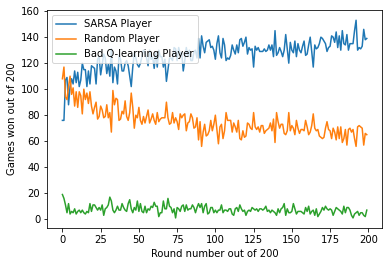

In [189]:
x = [i for i in range(200)]
player7y = [arr[0] for arr in results3]
player8y = [arr[1] for arr in results3]
player9y = [arr[2] for arr in results3]

plt.plot(x, player7y, label = p7.name)
plt.plot(x, player8y, label = p8.name)
plt.plot(x, player9y, label = p9.name)
plt.legend()
plt.ylabel('Games won out of 200')
plt.xlabel('Round number out of 200')
plt.show()

### Percentages of Games won Breakdown

Percentages may add up to be a little more than 100 but that is because if 2 players tie, we say they both "won." 

Note: lr = learning_rate and dc = disc_factor

In [181]:
# SARSA (0.01 lr 0.3 dc) vs. Random vs. Dumpling

frac1 = (sum(player1y) / 200) / 2
frac2 = (sum(player2y) / 200) / 2
frac3 = (sum(player3y) / 200) / 2
print(frac1, frac2, frac3)

64.0 17.92 22.8675


In [13]:
# SARSA (0.01 lr 0.3 dc) vs. SARSA (0.03 lr 0.7 dc) vs SARSA (0.01 lr 1 dc)

frac4 = (sum(player4y) / 200) / 2
frac5 = (sum(player5y) / 200) / 2
frac6 = (sum(player6y) / 200) / 2
print(frac4, frac5, frac6)

40.825 29.4525 35.945


In [190]:
# SARSA (0.01 lr 0.3 dc) vs. Random vs. Bad Q-learning

frac7 = (sum(player7y) / 200) / 2
frac8 = (sum(player8y) / 200) / 2
frac9 = (sum(player9y) / 200) / 2
print(frac7, frac8, frac9)

62.97 37.6675 3.7175
